# Import Modules

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime
from time import time
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torchmetrics import F1Score, ConfusionMatrix

# Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST("../datasets/", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("../datasets/", train=False, download=True, transform=transform)

# Dataloader

In [3]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

# Build Model

## Architecture

In [4]:
class Model(nn.Module):
    def __init__(self, n_feature):
        super(Model, self).__init__()
                
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_feature, 64),
            nn.Dropout(p=0.1),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(64, 10),
            nn.ReLU()
        )
        
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x_fc1)
        output = self.output(x_fc2)
        
        return output

model = Model(n_feature=28 * 28)
model

Model(
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Softmax(dim=1)
)

## Loss Function

In [5]:
loss_metric = nn.NLLLoss()
loss_metric

NLLLoss()

## Eval Metric

In [6]:
eval_metric = F1Score(num_classes=10)
eval_metric

F1Score()

## Optimizer 

In [7]:
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## Loop Function

In [8]:
def train(dataloader, model, loss_metric, eval_metric, optimizer, time):
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write("Train\n")
        
    print("Train\n")
    
    losses = []
    
    for batch, (feature, actual_label) in enumerate(dataloader, 1):
        # Forward Propagation
        pred_label = model(feature)
        loss = loss_metric(pred_label, actual_label)
        evaluate_metric = eval_metric(pred_label, actual_label)
        
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        losses.append(loss)
        
        if batch % 100 == 0:
            print(f"Batch-{batch:<4} | F1-Score: {evaluate_metric:>7f} | Loss: {loss:>7f}")
        
            with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
                f.write(f"Batch-{batch:<4} | F1-Score: {evaluate_metric:>7f} | Loss: {loss:>7f}\n")
            
    evaluate_metric = eval_metric.compute()
    loss = sum(losses) / len(dataloader)
    print(f"Accuracy : {evaluate_metric}")
    print(f"Loss     : {loss}\n")
    
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write(f"Accuracy : {evaluate_metric}\n")
        f.write(f"Loss     : {loss}\n\n")
        
    eval_metric.reset()
    
    return evaluate_metric, loss

def validate(dataloader, model, loss_metric, eval_metric, time):
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write("Test\n")
        
    print("Test\n")
    
    model.train()
    losses = []
    
    for batch, (feature, actual_label) in enumerate(dataloader, 1):
        # Forward Propagation
        pred_label = model(feature)
        loss = loss_metric(pred_label, actual_label)
        evaluate_metric = eval_metric(pred_label, actual_label)
        
        
        loss = loss.item()
        losses.append(loss)
        
        if batch % 100 == 0:
            print(f"Batch-{batch:<4} | F1-Score: {evaluate_metric:>7f} | Loss: {loss:>7f}")
        
            with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
                f.write(f"Batch-{batch:<4} | F1-Score: {evaluate_metric:>7f} | Loss: {loss:>7f}\n")
            
    evaluate_metric = eval_metric.compute()
    loss = sum(losses) / len(dataloader)
    print(f"Accuracy : {evaluate_metric}")
    print(f"Loss     : {loss}")
    
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write(f"Accuracy : {evaluate_metric}\n")
        f.write(f"Loss     : {loss}\n\n")
        
    eval_metric.reset()
    
    return evaluate_metric, loss

def loop(train, validate, epochs=5):
    now = datetime.now()
    now = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs("../callbacks/" + str(now) + "/models")
    os.makedirs("../callbacks/" + str(now) + "/logs")

    train_accuracies, train_losses = [], []
    test_accuracies, test_losses = [], []

    start = time()
    for epoch in range(epochs):
        with open("../callbacks/" + str(now) + "/logs/history.txt", "a") as f:
            f.write(f"EPOCH {epoch + 1}/{epochs}\n")
            f.write(f"{'=' * 46}\n")
            
        print(f"EPOCH {epoch + 1}/{epochs}")
        print("=" * 46, end="\n")
        acc_train, loss_train = train(train_loader, model, loss_metric, eval_metric, optimizer, now)
        acc_test, loss_test = validate(test_loader, model, loss_metric, eval_metric, now)
            
        print("=" * 46, end="\n\n")
        
        with open("../callbacks/" + str(now) + "/logs/history.txt", "a") as f:
            f.write(f"{'=' * 46}\n\n")
            
        train_accuracies.append(acc_train)
        train_losses.append(loss_train)
        test_accuracies.append(acc_test)
        test_losses.append(loss_test)
        
        torch.save(model.state_dict(), "../callbacks/" + now + "/models/epoch_" + str(epoch + 1) + ".pt")
    
    metrics = {
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "test_accuracies": test_accuracies,
        "test_losses": test_losses
    }
    
    torch.save(metrics, "../callbacks/" + now + "/logs/metrics.pt")

    print("SUMMARY:")
    print(f"Train Accuracy : {sum(train_accuracies) / len(train_accuracies)}")
    print(f"Train Loss     : {sum(train_losses) / len(train_losses)}\n")
    print(f"Test Accuracy  : {sum(test_accuracies) / len(test_accuracies)}")
    print(f"Test Loss      : {sum(test_losses) / len(test_losses)}")
    
    with open("../callbacks/" + now + "/logs/history.txt", "a") as f:
        f.write("SUMMARY:\n")
        f.write(f"Train Accuracy : {sum(train_accuracies) / len(train_accuracies)}\n")
        f.write(f"Train Loss     : {sum(train_losses) / len(train_losses)}\n\n")
        f.write(f"Test Accuracy  : {sum(test_accuracies) / len(test_accuracies)}\n")
        f.write(f"Test Loss      : {sum(test_losses) / len(test_losses)}\n")

    stop = time()

    total_time = stop - start
    print(f"Training time: {(total_time / 60):.3f} minutes")
    
    with open("../callbacks/" + now + "/logs/history.txt", "a") as f:
        f.write(f"Training time: {(total_time / 60):.3f} minutes")
        
    return {"train_accuracies": train_accuracies, "train_losses": train_losses, "test_accuracies": test_accuracies, "test_losses": test_losses}

summary = loop(train, validate)

EPOCH 1/5
Train

Batch-100  | F1-Score: 0.750000 | Loss: -0.651663
Batch-200  | F1-Score: 0.843750 | Loss: -0.775004
Batch-300  | F1-Score: 0.843750 | Loss: -0.750090
Batch-400  | F1-Score: 0.781250 | Loss: -0.782603
Batch-500  | F1-Score: 0.812500 | Loss: -0.825514
Batch-600  | F1-Score: 0.906250 | Loss: -0.856634
Batch-700  | F1-Score: 0.843750 | Loss: -0.784185
Batch-800  | F1-Score: 0.750000 | Loss: -0.732830
Batch-900  | F1-Score: 0.750000 | Loss: -0.746835
Batch-1000 | F1-Score: 0.812500 | Loss: -0.808451
Batch-1100 | F1-Score: 0.937500 | Loss: -0.902477
Batch-1200 | F1-Score: 0.718750 | Loss: -0.728080
Batch-1300 | F1-Score: 0.812500 | Loss: -0.802304
Batch-1400 | F1-Score: 0.875000 | Loss: -0.876217
Batch-1500 | F1-Score: 0.812500 | Loss: -0.791227
Batch-1600 | F1-Score: 0.906250 | Loss: -0.878115
Batch-1700 | F1-Score: 0.875000 | Loss: -0.879926
Batch-1800 | F1-Score: 0.812500 | Loss: -0.814272
Accuracy : 0.7914166450500488
Loss     : -0.7605975553154946

Test

Batch-100  | F1

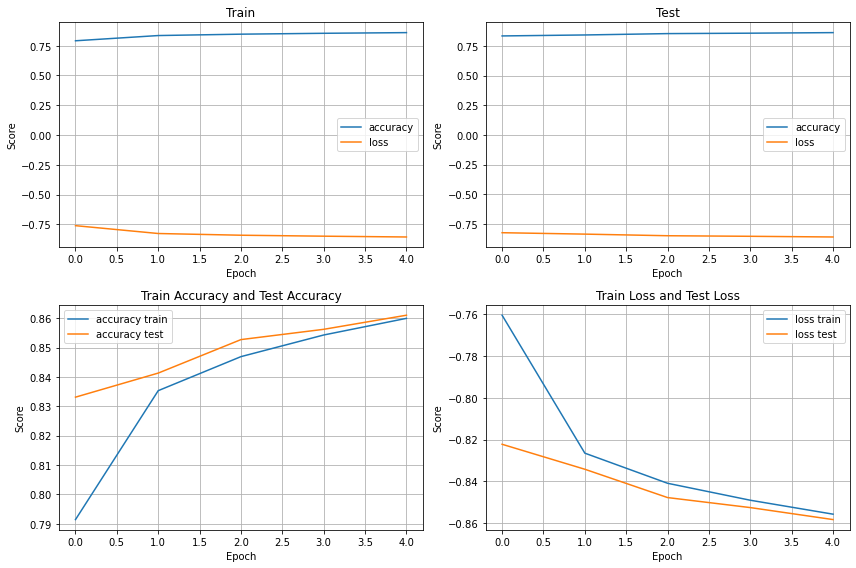

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(12, 8))

ax[0][0].set_title("Train")
ax[0][0].plot(summary["train_accuracies"], label="accuracy")
ax[0][0].plot(summary["train_losses"], label="loss")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Score")
ax[0][0].legend()
ax[0][0].grid();

ax[0][1].set_title("Test")
ax[0][1].plot(summary["test_accuracies"], label="accuracy")
ax[0][1].plot(summary["test_losses"], label="loss")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Score")
ax[0][1].legend()
ax[0][1].grid();

ax[1][0].set_title("Train Accuracy and Test Accuracy")
ax[1][0].plot(summary["train_accuracies"], label="accuracy train")
ax[1][0].plot(summary["test_accuracies"], label="accuracy test")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Score")
ax[1][0].legend()
ax[1][0].grid();

ax[1][1].set_title("Train Loss and Test Loss")
ax[1][1].plot(summary["train_losses"], label="loss train")
ax[1][1].plot(summary["test_losses"], label="loss test")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Score")
ax[1][1].legend()
ax[1][1].grid();

# Evaluate

## Predict with test dataset

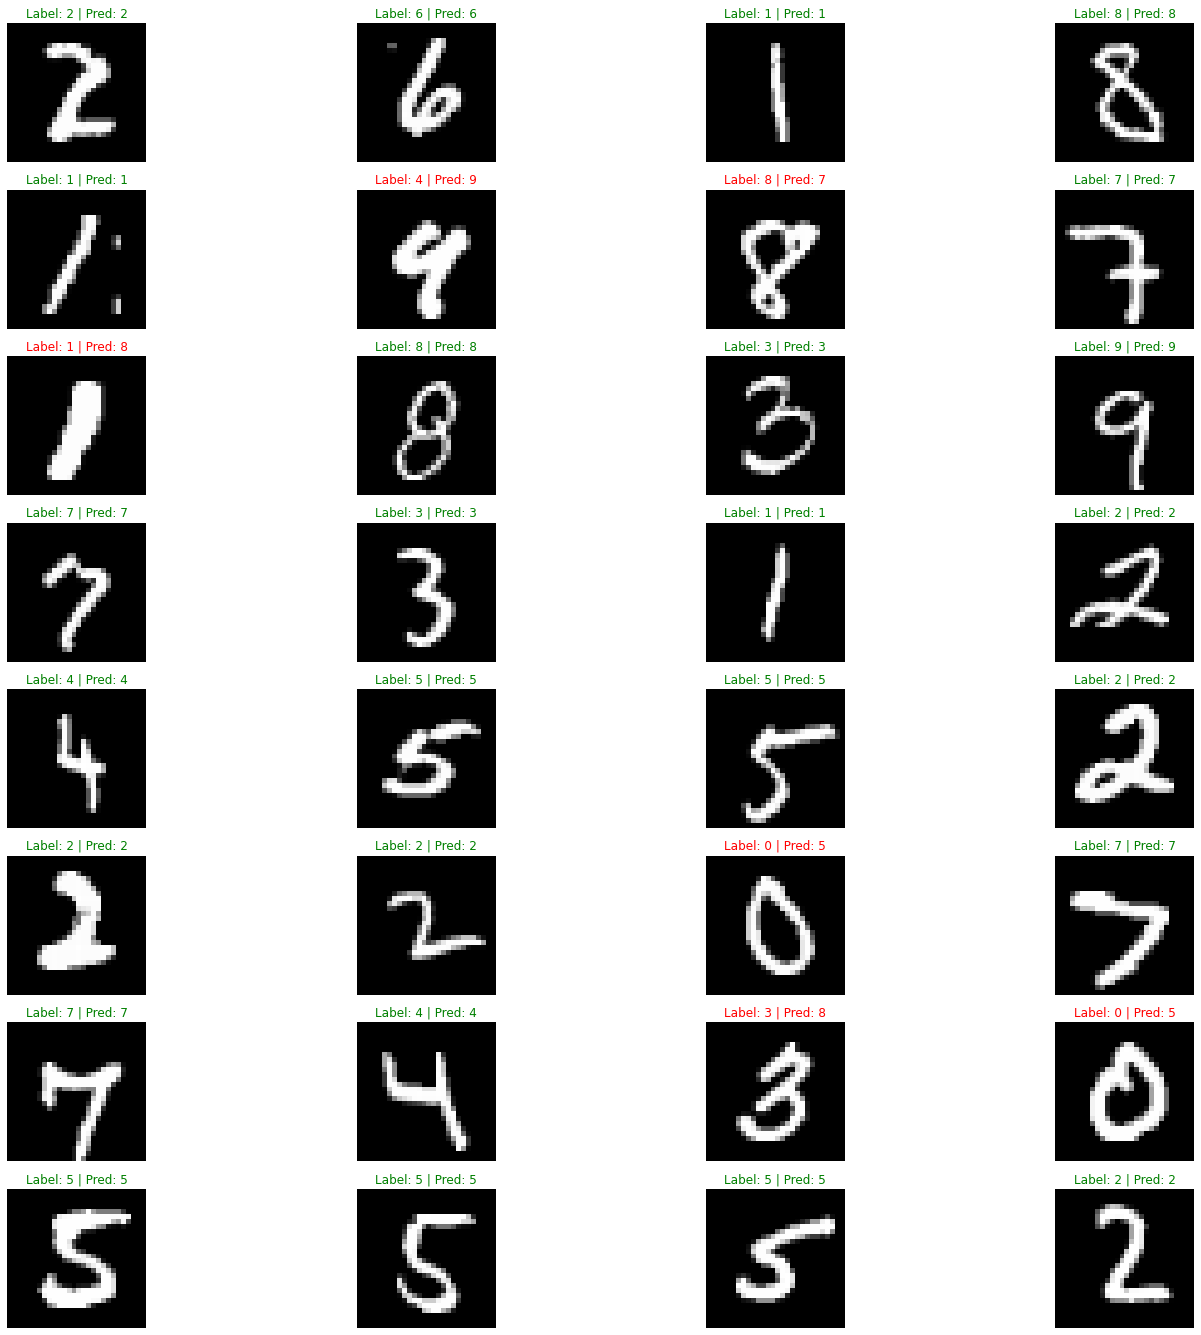

In [10]:
features, labels = next(iter(test_loader))

model.eval()
pred_labels = model(features).argmax(dim=1)

fig, axes = plt.subplots(8, 4, figsize=(24, 24))

for image, label, pred_label, ax in zip(features, labels, pred_labels, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    font = {"color": "red"} if label != pred_label else {"color": "green"}
    ax.set_title(f"Label: {label} | Pred: {pred_label}", fontdict=font)
    ax.axis("off")

## Confusion Matrix

In [11]:
def plot_confusion_matrix(model, dataloader):
    actual_labels = dataloader.dataset.targets
    features = dataloader.dataset.data.to(dtype=torch.float32)
    
    model.eval()
    pred_labels = model(features).argmax(dim=1)
    confusion_matrix = ConfusionMatrix(num_classes=10)
    
    ax = sns.heatmap(confusion_matrix(pred_labels, actual_labels), annot=True, fmt="d")
    ax.set(
        xlabel="Prediction",
        ylabel="Actual"
    );

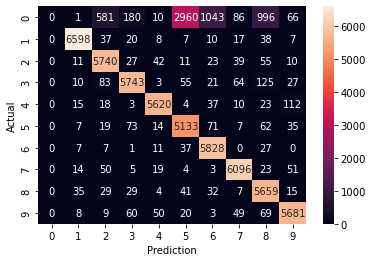

In [12]:
plot_confusion_matrix(model, train_loader)

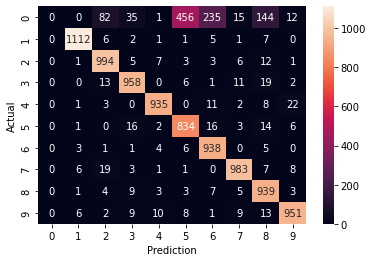

In [13]:
plot_confusion_matrix(model, test_loader)